# Construction of mixed-dimensional grids

In this tutorial, we will show:

1. How to define fractures and a fracture network in 2d and 3d domains.
2. How to construct a family of meshes that represent the domain, the fractures and their intersections.
3. Assembly of the grids into a `MixedDimensionalGrid` container that stores all grids and the geometric and topological relation between them.

Together, these are the first steps towards creating a simulation model for a mixed-dimensional problem in fractured domains.
For most simulation purposes, the final mixed-dimensional grid is all that is needed. Therefore, we start by showing a shortcut for obtaining a `MixedDimensionalGrid` given a set of fractures, a domain and mesh size parameters. All these will be described in more detail below.
We also mention that access to methods generating mixed-dimensional grids for a small selection of predefined fracture networks is available under `pp.applications.md_grids`.

The representation of a single fracture is handled by the `Fracture` class. Combining several fractures into a network is then handled by one of the classes `FractureNetwork2d` or `FractureNetwork3d`, depending on the dimension of the domain.

## Meshing of 2d fractures
A two-dimensional fracture is formed by specifying the coordinates of its two endpoints. These coordinates are collected into an array such that each column contains the coordinates of a specific point. The fractures are instantiated by the `LineFracture` class, which inherits from the `Fracture` class.

Below we define two fractures, one extending from (0,0) to (2,0) and one from (1,0) to (1,1). We then combine the geometry information into a fracture network by calling the method `create_fracture_network()`. This method in turn instantiates an object of the class `FractureNetwork2d`. 

In [1]:
import numpy as np
import porepy as pp

# Define a rectangular domain in terms of range in the two dimensions
bounding_box = {'xmin': -2, 'xmax': 3, 'ymin': -2, 'ymax': 3}
domain = pp.Domain(bounding_box=bounding_box)

# Define each individual fracture, collect into a list.
frac1 = pp.LineFracture(np.array([[0, 2],
                                  [0, 0]]))
frac2 = pp.LineFracture(np.array([[1, 1],
                                  [0, 1]]))
fractures = [frac1, frac2]

# Define a fracture network in 2d
network_2d = pp.create_fracture_network(fractures, domain)

We proceed by producing the fracture and matrix meshes, which are collected in a mixed-dimensional grid. This is done by calling the method `create_mdg()`, with the following input: The type of grid, meshing arguments and the fracture network. The different options of grid types are `"simplex"`, `"cartesian"` and `"tensor_grid"`. Various meshing arguments can be provided and are contained in a dictionary. Note that different grid types have different meshing arguments. In this case, we provide a value of an overall target cell size, as well as a smaller target cell size near the fractures. 

In [2]:
# Set overall target cell size and target cell size close to the fracture.
mesh_args: dict[str, float] = {"cell_size": 1.0, "cell_size_fracture": 0.3}

# Generate a mixed-dimensional grid
mdg = pp.create_mdg("simplex", mesh_args, network_2d)

Visualizing the network, we see that the two fractures form a Y (or T) type intersection. The intersection point is identified during meshing and assigned a zero-dimensional mesh. The plot of `mdg` shows how the chosen mesh arguments result in refinement towards the fractures.

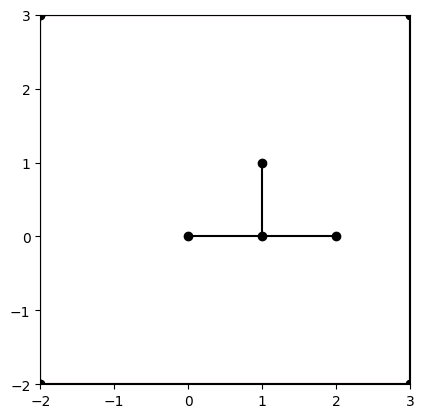

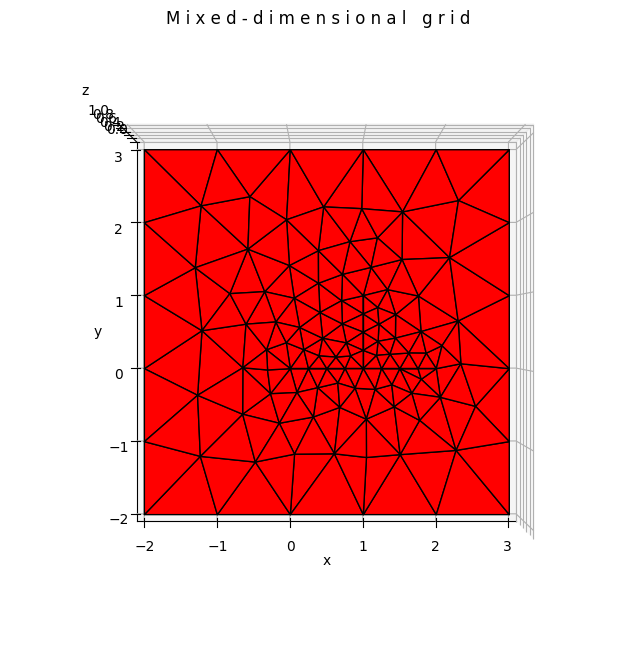

In [3]:
network_2d.plot()
pp.plot_grid(mdg, figsize=(8,8))

## Meshing of 3d fractures
Fractures in 3d are polygons instead of lines. They are defined much in the same way as for 2d fractures, namely by specifying the coordinates of the vertices of the polygon. Instantiation of the fractures is done by the `PlaneFracture` class, which once again inherits from the `Fracture` class. Note that when defining the mesh we are now specifying a minimum cell size, as well as a target cell size close to the external boundaries.

In [4]:
# The fractures are specified by their vertices, which are 3 x num_pts arrays
f_1 = pp.PlaneFracture(np.array([[0, 2, 2.5, 0],
                                 [0, 0, 1, 1],
                                 [0, 0, 1, 1]]))
f_2 = pp.PlaneFracture(np.array([[1, 1, 1, 1],
                                 [-1, 2, 2, -1],
                                 [-1, -1, 2, 2]]))
fractures = [f_1, f_2]

# Also define the domain
bounding_box = {'xmin': -1, 'xmax': 3, 'ymin': -2, 'ymax': 3, 'zmin': -1.5, 'zmax': 3}
domain = pp.Domain(bounding_box=bounding_box)

# Define a 3d FractureNetwork, similar to the 2d one
network = pp.create_fracture_network(fractures, domain)

# Generate the mixed-dimensional mesh
mesh_args = {'cell_size_boundary': 1.0, 'cell_size_fracture': 0.5, 'cell_size_min': 0.2}
mdg = pp.create_mdg("simplex", mesh_args, network)

## Import filters 
FractureNetworks (2d and 3d) can also be defined directly from files storing their data, see `pp.fracture_importer` for details. 

## Visualization of the mixed-dimensional grid
The set of meshes in the `MixedDimensionalGrid` can be exported for simulation by writing a .vtu file.
Then it can be visualized using, for instance, ParaView.

In [5]:
pp.Exporter(mdg, 'mixed_dimensional_grid').write_vtu()

By using some functionality within ParaView, we can see how the grids on fracture surfaces intersect with each other and with the matrix grid.

<img src='img/mixed_dimensional_grid.png'  width=600>

Note that in both of our examples of fracture networks we defined the bounding box to not intersect with the fractures. If the domain would have been smaller, fractures that intersect a face of the box would by default (can be overruled) have been truncated so that they are confined within the bounding box.

# Technical details

This section provides some more detail on the above demonstrated functionality and may be skipped for users with limited interest in technicalities. We focus on the the technicalities related to 3d meshing; in 2d, meshing is relatively simple (still difficult, but 3d is much worse). 

Functionality for fractures and their intersections is provided in the subpackage `porepy.fracs`. In addition to the above method of defining fractures through their vertices, we can also specify the fracture as an ellipsis, approximated as a polygon:

In [6]:
# Specify the fracture center
center = np.array([0.1, 0.3, 0.2])
# The minor and major axis
major_axis = 1.5
minor_axis = 0.5

# Rotate the major axis around the center.
# Note that the angle is measured in radians
major_axis_angle = np.pi/6

# So far, the fracture is located in the xy-plane. To define the incline, specify the strike angle, and the dip angle.
# Note that the dip rotation is carried out after the major_axis rotation (recall rotations are non-commutative).
strike_angle = -np.pi/3
dip_angle = -np.pi/3

# Finally, the number of points used to approximate the ellipsis.
# This is the only optional parameter; if not specified, 16 points will be used.
num_pt = 12
f_3 = pp.create_elliptic_fracture(center, major_axis, minor_axis, major_axis_angle, strike_angle, dip_angle, num_points=num_pt)

The fractures can be joined into a network in the same way as before:

In [7]:
network = pp.create_fracture_network([f_1, f_2, f_3])

We have not yet set a boundary for the fracture network, and effectively for
the domain. In the previous examples the bounding box was given on instantiation of the fracture network. However, it can also be imposed at a later point, in the following way:

In [8]:
# Define a domain based on its bounding box
bounding_box = {'xmin': -2, 'xmax': 3, 'ymin': -2, 'ymax': 3, 'zmin': -3, 'zmax': 3}
domain = pp.Domain(bounding_box)
_ = network.impose_external_boundary(domain)

## Meshing

Our aim is to create a computational mesh that conforms to the fractures and their intersections (1d lines, 0d points). For the actual grid construction, we rely on Gmsh. However, Gmsh requires that the geometric constraints, that is the fractures, are described as *non-intersecting* polygons. It only takes some thinking to understand why the meshing software would not like to do this themselves; this is a highly challenging task.

PorePy provides functionality for finding intersections between fractures, and splitting them into non-intersecting polygons. Intersections are found by 

In [9]:
network.split_intersections()

### Geometric tolerances and stability of meshing algorithm
A critical concept in meshing of fractured domains is the concept of geometric tolerance: Since we are operating in finite precision aritmethics, two points may or may not be consider equal (or similarly, two lines/planes may or may not intersect), depending on how accurately we consider their representation. At least three concepts come into play here:

1. The accuracy of the numerical representation of the objects (accumulated effect of finite precision rounding errors).
2. The accuracy in geological interpretation of fracture data. As an example, if the fracture network originates from an interpretation of satellite images, differences measured in centimeters should be treated with some caution.
3. The resolution of the computational grid: If points with a certain distance are considered non-equal, this may also require that we resolve their difference in the mesh. In addition, the mesh generator will use its own concept of geometric tolerance for internal calculations.

In PorePy, we attempt to resolve these issues as follows: The `FractureNetwork3d` (and the corresponding `FractureNetwork2d`) has an attribute `tol` that represents the geometric tolerance used in the calculation of intersections and subsequent splitting of the fractures. If meshing is done with gmsh, the tolerances used in PorePy and gmsh are related. The approach works reasonably well, but for complex configurations of fracture intersections, stability issues can arise. 

### Interaction with gmsh

Now, we want to create grids for the domain, as well as for fractures and fracture intersections. This involves creating a config file for the mesh generator that contains geometry description, including fracture planes and their intersections. The mesh is then created by calling gmsh. The resulting mesh information is read back to python, and `Grid` objects representing the matrix, fractures and fracture intersections are created.



Gmsh is quite flexible in terms of letting the user set/guide the preferred mesh size in different parts of the domain. PorePy tries to adjust to this by adapting the specified mesh size to the geometry. As we have seen previously, the user can specify the mesh sizes by tuning the parameters `cell_size`, `cell_size_min`, `cell_size_fracture` and `cell_size_boundary`. What actually happens with the mesh, that is, how Gmsh translates these preferred options into a grid, is another matter. It may take some practice to get this to work properly.

If an acceptable mesh cannot be generated by tuning these parameters, more fine-tuned mesh generation can be achieved directly in Gmsh. A typical workflow would be first to generate a gmsh configuration file using the function `FractureNetwork.prepare_for_gmsh()`, then generate the mesh from Gmsh proper and store it to a .msh file, and finally import the mesh using the functions from `pp.fracture_importer` to obtain a `MixedDimensionalGrid`.

# What we have explored
Fractures in PorePy are defined as convex planes (in 3d) or lines (in 2d). A `FractureNetwork` is a domain that contains a set of fractures, and it is constructed by invoking the method `create_fracture_network()`. A mixed-dimensional mesh is constructed by invoking the method `create_mdg()`. The actual mesh is constructed by the external package Gmsh.